<table>
    <tr>
        <td>
        <center>
        <font size="+1">If you haven't used BigQuery datasets on Kaggle previously, check out the <a href = "https://www.kaggle.com/rtatman/sql-scavenger-hunt-handbook/">Scavenger Hunt Handbook</a> kernel to get started.</font>
        </center>
        </td>
    </tr>
</table>

___ 

## Previous days:

* [**Day 1:** SELECT, FROM & WHERE](https://www.kaggle.com/rtatman/sql-scavenger-hunt-day-1/)
* [**Day 2:** GROUP BY, HAVING & COUNT()](https://www.kaggle.com/rtatman/sql-scavenger-hunt-day-2/)
* [**Day 3:** ORDER BY & Dates](https://www.kaggle.com/rtatman/sql-scavenger-hunt-day-3/)

____


## AS & WITH
___

So far we've learned how to use these clauses in our queries: 

    SELECT ... 
    FROM ...
    (WHERE) ...
    GROUP BY ...
    (HAVING) ...
    ORDER BY
By this point, our queries are getting pretty long, which can make them hard to puzzle out exactly what we're asking for.

We've also started using functions like EXTRACT() to get information out of dates or aggregate functions like COUNT(). You may have noticed, however, that the columns that we use these functions are are returned with names like `_f0` and `_f1`, which aren't very helpful.

Don't worry, though, we're going to learn how to get around both of these problems. Today, we're going to learn how to use AS and WITH to tidy up our queries and make them easier to read.

### AS
___

First, let's talk about the AS clause. AS lets you refer to the the columns generated by your queries with different names, which is also know as "aliasing". (If you use Python a lot you might already have used `as` for aliasing if you've ever done something like `import pandas as pd` or `imports seaborn as sns`.)

To use AS in SQL, you just insert it right after the name of the column you select. Here's an example of a query **without** an AS clause:  

        SELECT EXTRACT(DAY FROM column_with_timestamp), data_point_3
        FROM `bigquery-public-data.imaginary_dataset.imaginary_table`
And here's an example of the same query, but with AS.

        SELECT EXTRACT(DAY FROM column_with_timestamp) AS day,
                data_point_3 AS data
        FROM `bigquery-public-data.imaginary_dataset.imaginary_table`
Both of these queries will return the exact same table, but in the second query the columns returned will be called `day` and `data`, rather than the default names of `_f0` and `data_point_3`.

### WITH... AS
____

On its own, AS is a convenient way to make your code easier to read and tidy up the data returned by your query. It's even more powerful when combined with WITH in what's called a "common table expression" or CTE.

> **Common table expression**: A temporary table that you return within your query. You can then write queries against the new table you've created. CTE's only exist inside the query where you create them, though, so you can't reference them in later queries.

CTE's are very helpful for breaking up your queries into readable chunks and make it easier to follow what's going on in your code. 

Let's look at how to use them. We're going to be the same small Pets table that we've been working with previously, but now it includes information on the ages of all the different animals. These are in a column called "Years_old":

![](https://i.imgur.com/01s9TwR.png)

We might want to ask questions about older animals in particular. One way that we could do this is to create a CTE that only contains information about older animals and then write get information about it. So we can create a CTE which only contains information about animals more than five years old like this:

    # note that this query won't return anything!
    WITH Seniors AS 
            (
                SELECT ID, Name
                FROM `bigquery-public-data.pet_records.pets`
                WHERE Years_old > 5
            )
This will create the following temporary table that we can then refer to in the rest of our query, which only has the ID and Name of the animals that are seniors:

![](https://i.imgur.com/LBippKL.png)

If we wanted additional information about this table, we can write a query under it. So this query will create the CTE shown above, and then return all the ID's from it (in this case just 2 and 4).

    WITH Seniors AS 
            (
                SELECT ID, Name
                FROM `bigquery-public-data.pet_records.pets`
                WHERE Years_old > 5
            )
    SELECT ID
    FROM Seniors
We could do this without a CTE, but if this were the first part of a very long query, removing the CTE would make it much harder to follow.

## Example: How many Bitcoin transactions are made per month?
____

Now let's work through an example with a real dataset. Today, we're going to be working with a Bitcoin dataset (Bitcoin is a popular but volatile cryptocurrency). We're going to use a common table expression (CTE) to find out how many Bitcoin transactions were made per month for the entire timespan of this dataset.

First, just like the last three days, we need to get our environment set up:

In [ ]:
# import package with helper functions 
import bq_helper

# create a helper object for this dataset
bitcoin_blockchain = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                              dataset_name="bitcoin_blockchain")

Now we're going to write a query to get the number of transactions per month. One problem here is that this dataset uses timestamps rather than dates, and they're stored in this dataset as integers. We'll have to convert these into a format that BigQuery recognizes using TIMESTAMP_MILLIS(). We can do that using a CTE and then write a second part of the query against the new, temporary table we created. This has the advantage of breaking up our query into two, logical parts. 

* Convert the integer to a timestamp
* Get information on the date of transactions from the timestamp

You can see the query I used to do this below.

In [6]:
query = """ WITH time AS 
            (
                SELECT TIMESTAMP_MILLIS(timestamp) AS trans_time,
                    transaction_id
                FROM `bigquery-public-data.bitcoin_blockchain.transactions`
            )
            SELECT COUNT(transaction_id) AS transactions,
                EXTRACT(MONTH FROM trans_time) AS month,
                EXTRACT(YEAR FROM trans_time) AS year
            FROM time
            GROUP BY year, month 
            ORDER BY year, month
        """

# note that max_gb_scanned is set to 21, rather than 1
transactions_per_month = bitcoin_blockchain.query_to_pandas_safe(query, max_gb_scanned=21)

Since they're returned sorted, we can just plot the raw results to show us the number of Bitcoin transactions per month over the whole timespan of this dataset.

Text(0.5,1,'Monthly Bitcoin Transcations')

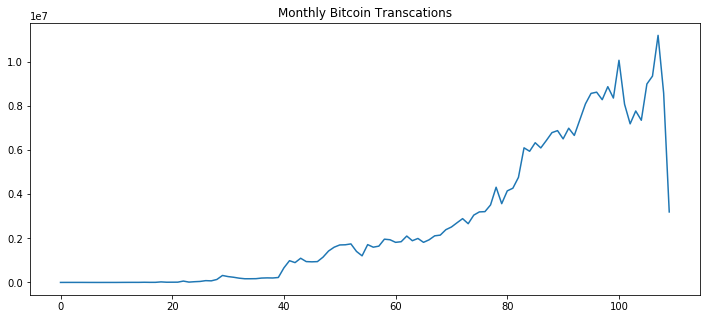

In [7]:
# import plotting library
import matplotlib.pyplot as plt

# plot monthly bitcoin transactions
fig = plt.figure(figsize=(12,5))

plt.plot(transactions_per_month.transactions)
plt.title("Monthly Bitcoin Transcations")

Pretty cool, huh? :)

As you can see, common table expressions let you shift a lot of your data cleaning into SQL. That's an especially good thing in the case of BigQuery because it lets you take advantage of BigQuery's parallelization, which means you'll get your results more quickly.

# Scavenger hunt
___

> **Important note**: Today's dataset is bigger than the ones we've used previously, so your queries will be more than 1 Gigabyte. You can still run them by setting the "max_gb_scanned" argument in the `query_to_pandas_safe()` function to be large enough to run your query, or by using the `query_to_pandas()` function instead.

Now it's your turn! Here are the questions I would like you to get the data to answer. Practice using at least one alias in each query. 

* How many Bitcoin transactions were made each day in 2017?
    * You can use the "timestamp" column from the "transactions" table to answer this question. You can check the [notebook from Day 3](https://www.kaggle.com/rtatman/sql-scavenger-hunt-day-3/) for more information on timestamps.
* How many transactions are associated with each merkle root?
    * You can use the "merkle_root" and "transaction_id" columns in the "transactions" table to answer this question. 
    * Note that the earlier version of this question asked "How many *blocks* are associated with each merkle root?", which would be one block for each root. Apologies for the confusion!

In order to answer these questions, you can fork this notebook by hitting the blue "Fork Notebook" at the very top of this page (you may have to scroll up). "Forking" something is making a copy of it that you can edit on your own without changing the original.

### Q1) How many Bitcoin transactions were made each day in 2017?

In [8]:
# Your code goes here :)

query1 = """
        WITH time AS (
            SELECT TIMESTAMP_MILLIS(timestamp) AS trans_time, transaction_id
            FROM `bigquery-public-data.bitcoin_blockchain.transactions`
        )
        SELECT COUNT(transaction_id) AS transactions, EXTRACT(DATE from trans_time) as date
        FROM time
        WHERE EXTRACT(YEAR from trans_time) = 2017
        GROUP BY date
        """


In [10]:
# note that max_gb_scanned is set to 21, rather than 1
transactions_per_day = bitcoin_blockchain.query_to_pandas_safe(query1, max_gb_scanned=21)


In [22]:
transactions_per_day.head()

,transactions,date
0,276225,2017-09-06
1,308482,2017-03-10
2,317698,2017-05-12
3,279811,2017-06-28
4,261891,2017-08-27


In [23]:
transactions_per_day.to_csv('transactions_per_day.csv')

Text(0.5,1,'Bitcoin transactions made each day in 2017')

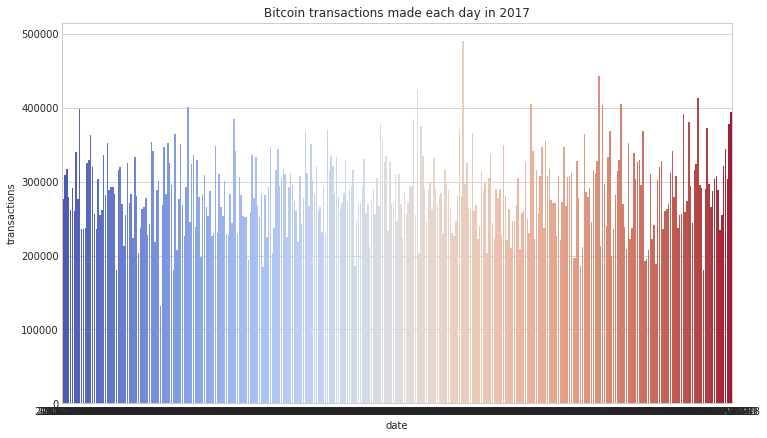

In [27]:
import seaborn as sns

ax = plt.subplots(figsize=(12, 7))
sns.set_style("whitegrid") 
ax = sns.barplot(x="date", y="transactions", data=transactions_per_day, palette="coolwarm")
plt.title("Bitcoin transactions made each day in 2017")

Text(0.5,1,'Bitcoin transactions made each day in 2017')

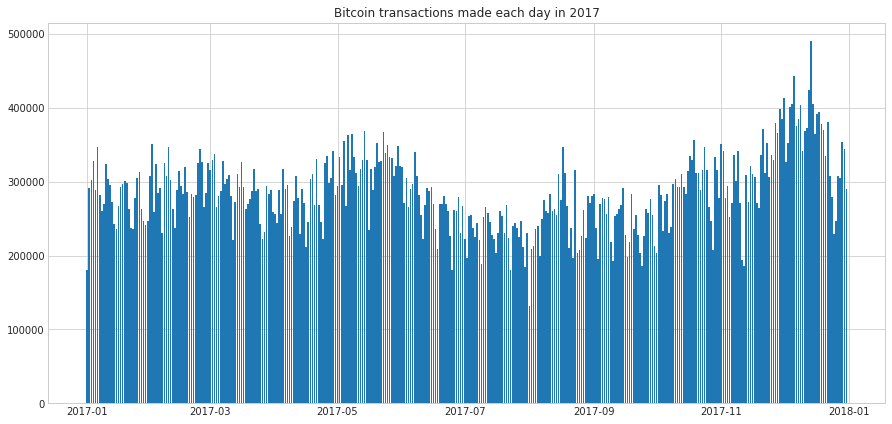

In [28]:
# OR

ax = plt.subplots(figsize=(15,7))
plt.bar(transactions_per_day.date, transactions_per_day.transactions)
plt.title("Bitcoin transactions made each day in 2017")


### Q2) How many transactions are associated with each merkle root?

In [30]:
bitcoin_blockchain.head("transactions")

,timestamp,transaction_id,inputs,outputs,block_id,previous_block,merkle_root,nonce,version,work_terahash,work_error
0,1482444096000,97691cd5ca4e6b614d49b36a38c3379cc7b5da637158c1...,"[{'input_script_bytes': b""G0D\x02 *N\x9a\x1c\x...","[{'output_satoshis': 994, 'output_script_bytes...",0000000000000000000940a4895e3bf0e8e6c81e60768c...,0000000000000000030682be8b3d1272b2db7d240f1f66...,5d0a74f90b56f4930d8a931436b2f49d47d137c3ea1882...,3803265493,536870914,13321209935,None
1,1477306252000,d70d328c4f38c122c9eb81be5085c5319734660897bb98...,[{'input_script_bytes': b'G0D\x02 8\x8a\xd6@\x...,"[{'output_satoshis': 76579, 'output_script_byt...",0000000000000000001bd57b04e3ca4b1d878f0f64411d...,000000000000000003c6f88ec12ada31ed06905229bf51...,de2041a2b2b5976b4e4e2d89a5f1a5e9d91171a3ef9e9e...,2035999080,536870912,10892986963,None
2,1438844928000,b5c96e4011958a0b7ddaa5268059e1727b86bb083ae4cf...,[{'input_script_bytes': b'G0D\x02 c#TB&\xc5\x1...,"[{'output_satoshis': 11037, 'output_script_byt...",000000000000000010ee4f8279f1b471cddbdde4a1b231...,00000000000000000c4f69c66e58d5c83085c5e68c8d25...,0a7324e45720a16fc0eab7e6f8c02d6e94d21c27765522...,2087473253,3,2245370357,None
3,1497419259000,f0b7b4c5dab1f1a4e4e074203b62e897fec5b8ec342eae...,"[{'input_script_bytes': b""H0E\x02!\x00\x9f\x83...","[{'output_satoshis': 23228379007, 'output_scri...",000000000000000000539e9014f6f12e69c4e823d14d7f...,000000000000000000526ae607738a013b1675919f4b94...,cdda52178e115a49b8748128fae8d362a7360f9a1c1ce2...,1732468769,536870912,29152969585,None
4,1435778360000,8aac1bcd405944bd06a96ad9d2261b93826756a615567a...,[{'input_script_bytes': b'I0F\x02!\x00\x9fW\xb...,"[{'output_satoshis': 15000000, 'output_script_...",000000000000000014542a6e6ff37f68f6556b58c52f11...,00000000000000000df6d8b5d1f8f830cb51ab35c799fc...,c7d37d470acf1fb4e3c80c2d0912d71d2fa1436093387b...,2805975484,3,2121832761,None


In [32]:
bitcoin_blockchain.head('blocks')

,block_id,previous_block,merkle_root,timestamp,difficultyTarget,nonce,version,work_terahash,work_error,transactions,row_number
0,00000000b1a0b6efd5dcb96f42c49d59c5a370625ead79...,0000000099c584e4ef5403c7d2dadad3fb0217c8f5a0ef...,3a4947f08e15d0a48e67940b764aac6da2a0344225734c...,1235043245000,486604799,2936862508,1,0,None,[{'transaction_id': '3a4947f08e15d0a48e67940b7...,1
1,00000000000000000c2b75113c6d2539f436ee9ac90abf...,00000000000000001707a26e9773da6693075b5d87c1f7...,cade22d5b36e04305859111c02c19974503e0775d03c74...,1431331343000,404165597,1489599821,3,2046299587,None,[{'transaction_id': '1c836ea5aa68b8e6f0d447d61...,1
2,000000000000000000a9d91a22d16697a8cd559d31713f...,00000000000000000015b7f8a0743714dfbbc666cb9304...,29f28a60d34918e287dc85bd7f82cebc4bb8936c5b2a05...,1457872018000,403108008,1250702642,4,6804500418,None,[{'transaction_id': '66cc943f5b5d828d6f91e0b47...,1
3,000000000000000004e992cc78fc73c089f06106ef98e3...,000000000000000002382c25d8515d71c4b0283429dd20...,909b162695d05903062f6abeff459e8731bbd4972848de...,1452046609000,403346833,2047471761,4,4461694745,None,[{'transaction_id': '190487552f996f532dd1aba76...,1
4,0000000000000165234f1dd6eb47ed655cc8141b33b0bc...,0000000000000159ed8d84e666cd37377e82fe1d677b9b...,2c16efeb2e968fa31baee1861d2a37ee44998bec012b50...,1353511797000,436533995,2720655894,1,144689,None,[{'transaction_id': 'e108e447c71a358a8c6a752ed...,1


In [33]:
query2 = """
        SELECT COUNT(transaction_id) as transactions, merkle_root
        FROM `bigquery-public-data.bitcoin_blockchain.transactions`
        GROUP BY merkle_root
        ORDER BY transactions DESC
        """

In [37]:
# note that max_gb_scanned is set to 37, rather than 1
transactions_merkle_root = bitcoin_blockchain.query_to_pandas_safe(query2, max_gb_scanned=37)


In [38]:
transactions_merkle_root.head()

,transactions,merkle_root
0,12239,dc1bde29f6912ba825138118676988a0e7f839054155db...
1,9647,03ef22104e4561d1c8198015157aa80ec08f1aaef676bf...
2,6451,52461d6e9d181204112ee8ca440921d5df88763ddb6e86...
3,6144,60f1b83982cd4588a8a99b66bb24c5e6d7bb15d34c6a90...
4,6084,73733e699f12f312843b99b309d65ac499c57507d2120f...


In [ ]:
transactions_merkle_root.to_csv('transactions_merkle_root.csv')